# IMDB GRU, (RNN, LSTM)

RNN은 순서와 맥락을 고려하지는 않음
-> 일치하는 단어가 얼마나 있는가를 확인

## #01. 텍스트 분석 알고리즘

### 1. 텍스트 분석을 위해 개선된 알고리즘의 종류

#### GRU
> 이게 최고임

- 게이트 메커니즘이 적용된 RNN의 일종으로 LSTM에서 영감을 받았으며 더 간략한 구조를 갖는다.
- 한국인 조경현 박사님이 제안한 방법

#### RNN

- Embedding층은 단순하게 데이터의 표현을 학습하여 데이터 사전을 구축하는 것
- 하지만 유사한 의미의 단어를 비슷한 공간에 매핑할 수 있지만, 시퀀스 데이터의 중요한 특성인 순서와 맥락까지 고려한 것은 아니다.
- 순환 신경망은 이 문제를 해결하기 위해 고안된 층
- 완전연결층, 컨볼루션 신경망의 반대되는 개념.
- 완전연결층과 컨볼루션 신경망은 피드 포워드 네트워크(feed-forward network)라고 표현
- 피드 포워드 네트워크는 신경망이 가지는 모든 출력값이 마지막층인 출력층을 향한다.
- 하지만 순환 신경망은 각 층의 결과값이 출력층을 향하면서도 동시에 현재 층의 다음 계산에 사용된다.

#### LSTM

- RNN의 그래디언트 손실문제를 보완한 방법
- 정보를 여러 시점에 걸쳐 나르는 장치(‘Cell state’)가 추가되었다.
- 이로 인해 그래디언트를 보존할 수 있어 그래디언트 손실 문제가 발생하지 않도록 도와준다.

### 2. 텍스트 분석 알고리즘 적용하기

전체 소스코드는 지금까지의 예제들과 동일하게 진행된다.

```
💡 패키지 준비 → 데이터셋 준비 → 데이터 전처리 → 탐색적 데이터 분석(문자열 토큰화, 데이터를 동일한 길이로 맞추기) → 데이터 셋 분할 → 모델 개발(정의+학습) → 학습 결과 평가 → 학습결과 적용
```

이 과정에서 학습 모델을 정의하는 부분에서 적용할 알고리즘만 변경하면 되기 때문에 여기서는 RNN을 먼저 적용해 본 후, 학습 모델을 LSTM과 GRU로 각각 변경하여 다시 학습을 수행해 보도록 한다.

학습 시간이 매우 오래 걸리는 예제이므로 가급적 GPU가 탑재된 컴퓨터에서 실습하는 것이 좋다.

## #01. 패키지 준비

In [ ]:
import sys
import os
sys.path.append("/content/drive/MyDrive/DLMLJUPYTER")
import helper_colab
from pandas import DataFrame
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, GRU #SimpleRNN, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.datasets import imdb

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## #02. 데이터 준비

In [ ]:
# 가장 빈번하게 사용되는 단어의 개수 예제 데이터 다운로드
num_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = num_words)
print(f"훈련 데이터 {x_train.shape} 레이블 {y_train.shape}")
print(f"훈련 데이터 {x_test.shape} 레이블 {y_test.shape}")

훈련 데이터 (25000,) 레이블 (25000,)
훈련 데이터 (25000,) 레이블 (25000,)


## #03. 데이터 전처리

### 1. 데이터를 동일한 길이로 맞추기 (padding)

Embedding층을 사용하기 위해서는 시퀀스 데이터(여기서는 문장을 나타냄)의 길이가 전부 동일해야 한다.

길이를 맞추기 위해 pad_sequences() 함수 사용

- 데이터가 지정해준 길이보다 짧은 경우 0으로 채워 넣으며, 긴 경우는 잘라낸다.
- 단어의 뒤에 패딩을 추가하고 싶다면, padding 인자를 post로 지정한다.

> Embedding(임베딩)은 문장의 길이를 동일하게 맞추는 것

padding에는 pre(앞에 0)와 post(뒤에 0)가 존재

- pre-padding일 경우에는 앞단에 0이 채워져 마지막 단어로 제로 패딩이 입력으로 들어가는 일 없이 올바른 시퀀스 모델링이 진행
- post-padding일 경우에는 뒷단에 0이 채워져 마지막 단어로 제로 패딩이 입력으로 사용

In [ ]:
# 최대 문장 길이
max_len = 500

print("padding 이전 :", len(x_train[0]), len(x_train[1]))

pad_x_train = pad_sequences(x_train, maxlen=max_len, padding='pre')
pad_x_test = pad_sequences(x_test, maxlen=max_len, padding='pre')

#  pre-padding으로 원래 단어의 앞에 '지정해준 단어의 길이 – 원래 단어의 길이' (500 –218)만큼 0이 추가된 것을 볼 수 있다.
print('padding 이후 :', len(pad_x_train[0]), len(pad_x_train[1]))

padding 이전 : 218 189
padding 이후 : 500 500


#### pre-padding 결과 확인

In [ ]:
print(pad_x_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
print(pad_x_train[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

## #04. 탐색적 데이터 분석

> 실전에서는 **탐색적 데이터분석** 과정에서 긍정/부정의 비율이 동일한지 확인 후 모델을 개발하고 학습을 진행. 이 과정을 건너뛰면 모델 생성, 학습이 제대로 되지 않음. -> 데이터 비율이 맞지 않기 때문임.

여기서는 동일한 비율로 나눈 예제 데이터를 사용하기 때문에 생략.

## #05. 데이터 셋 분할하기

이미 데이터셋이 훈련데이터와 검증데이터로 분리되어 있기 때문에 별도의 분할 작업을 수행할 필요는 없다.

> 실제로는 **탐색적 데이터분석** 과정에서 긍정/부정의 비율이 동일한지 확인 후 모델을 개발, 학습을 진행. 이 과정을 건너뛰면 모델 생성, 학습이 제대로 되지 않음.

## #06. 모델 개발

### 모델 정의 (GRU)

return_sequences 파라미터가 True로 지정되면 모든 학습 시점의 은닉 상태를 출력해 준다. False인 경우는 마지막 시점의 은닉 상태만 출력한다. (기본값=False)

dropout은 지정된 비율만큼 학습을 건너뛰게 하는 파라미터. 이 파라미터를 사용하게 되면 과거 학습정보를 잃어버릴 확률이 높아지고 그에 따라 모델 성능이 나빠질 가능성이 있다.

>dropout은 무작위로 건너뛰는 비율로 학습 속도는 향상되지만 과거 학습 정보를 잃어버릴 확률이 높아져 모델의 성능 저하가 발생할 수 있음.

recurrent_dropout(순환드롭아웃)은 과거 학습정보를 잃어버리는 문제를 해결하기 위해 적용하는 옵션.

- --------------------

> Embedding층은 모델의 첫 번째 층으로만 사용할 수 있으며, 주로 순환 신경망과 연결하여 사용.

- --------------------

 > filter가 클수록, kernel_size가 작을 수록 모델이 성능이 개선됨.
 단, 학습 시간도 오래 걸림.

> activation : 다중분류 = softmax, unit 10, 이진분류 = sigmoid, unit 1/0 - 주로 `relu`

> loss : 다중분류 = categorical_crossentropy, 이진분류 = binary_crossentropy

> Sequential : 모델을 하나 하나 차례로 집어 넣는다

> Dense : 완전 연결 층

> optimizer : 경사하강법 변화 버전(sgd, adam 등등)

> metrics : 평가지표(학습 판단 기준) mse, mae, acc 등

In [ ]:
model = Sequential()

model.add(Embedding(input_dim = num_words, output_dim = 32, input_length = max_len))
# 딱 한 층만 쌓아올림. -> 그래서 최고
model.add(GRU(32))  #뉴런 32
model.add(Dense(1, activation='sigmoid'))   #이진분류 = sigmoid

# 결국은 긍정, 부정을 분류 하는 문제이므로 이진분류에 해당한다.
model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           320000    
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 326369 (1.24 MB)
Trainable params: 326369 (1.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

- epochs는 많아도 크게 상관이 없음(단, 너무 크면 오래 걸리고 검증 오차가 증가)
    - callback을 사용해 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링
    - EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ReduceLROnPlateau EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ModelCheckpoint 지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

In [ ]:
%%time
result = model.fit(pad_x_train, y_train, epochs=500, validation_data=(pad_x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
782/782 [==============================] - 224s 283ms/step - loss: 0.4441 - acc: 0.7863 - val_loss: 0.3260 - val_acc: 0.8652 - lr: 0.0010
Epoch 2/500
782/782 [==============================] - 226s 289ms/step - loss: 0.2554 - acc: 0.8999 - val_loss: 0.3036 - val_acc: 0.8734 - lr: 0.0010
Epoch 3/500
782/782 [==============================] - 227s 290ms/step - loss: 0.1908 - acc: 0.9287 - val_loss: 0.3207 - val_acc: 0.8702 - lr: 0.0010
Epoch 4/500
782/782 [==============================] - 225s 288ms/step - loss: 0.1430 - acc: 0.9482 - val_loss: 0.3587 - val_acc: 0.8692 - lr: 0.0010
Epoch 5/500
782/782 [==============================] - ETA: 0s - loss: 0.1018 - acc: 0.9651
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 [==============================] - 227s 290ms/step - loss: 0.1018 - acc: 0.9651 - val_loss: 0.3789 - val_acc: 0.8652 - lr: 0.0010
Epoch 6/500
782/782 [==============================] - 227s 291ms/step - loss: 0.0581 - acc: 0

## #05. 학습결과 평가

In [ ]:
from matplotlib import pyplot as plt

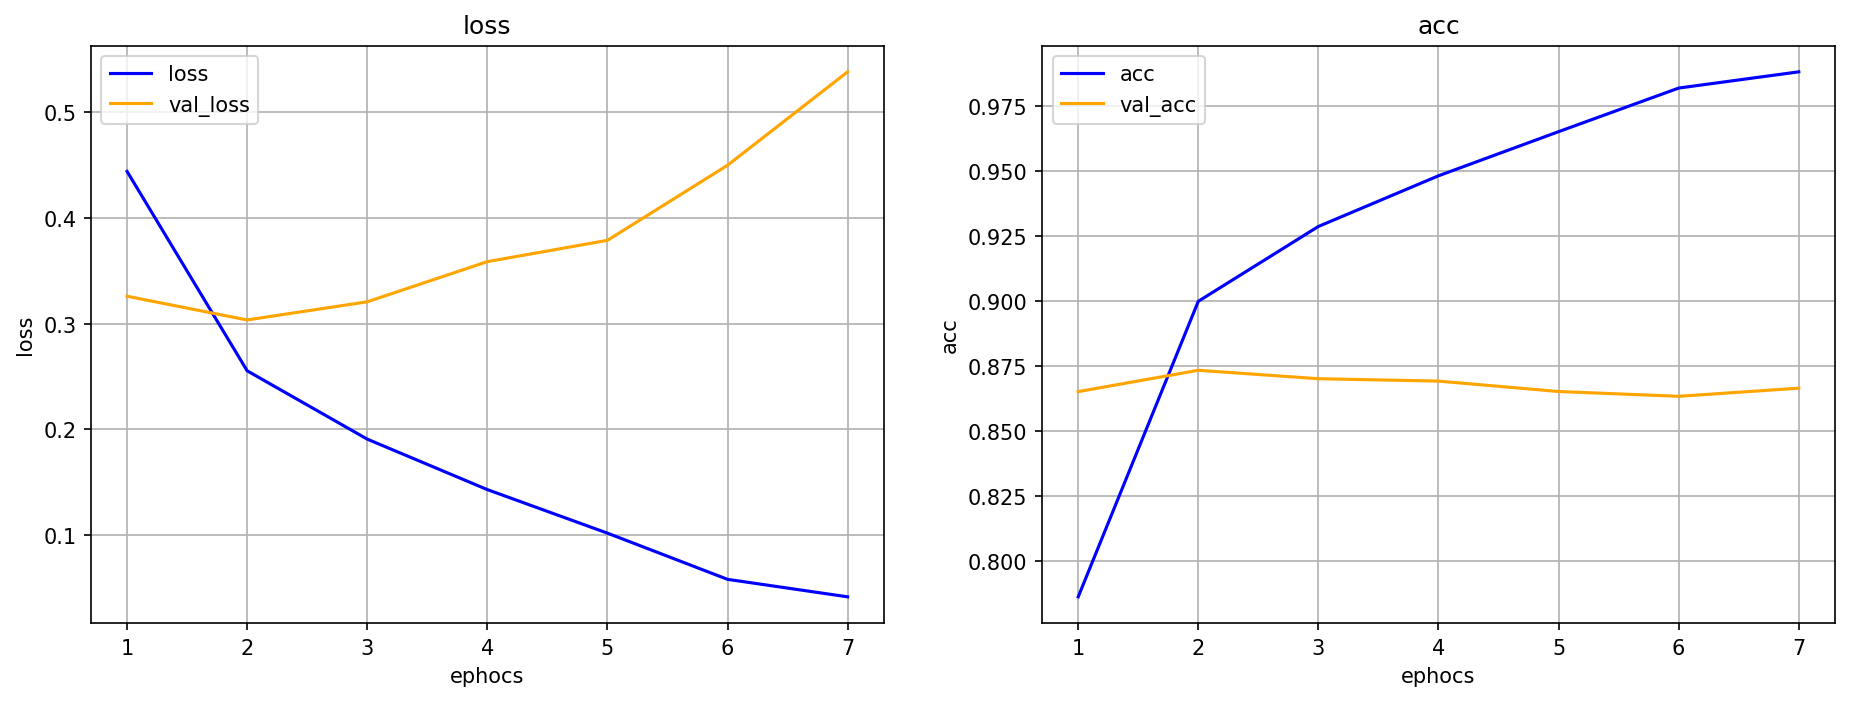

In [ ]:
# helper_colab.tf_result_plot(result)

result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)

# 학습 결과 그래프의 컬럼 명
column_names = result_df.columns

# 학습데이터에 대한 필드이름
train_column_name = [column_names[0], column_names[1]]

# 검증데이터에 대한 필드이름
test_column_name = [column_names[2], column_names[3]]

# 학습 결과 그래프

# # 그래프 객체 생성
fig, ax = plt.subplots(1,2, figsize=(15, 5), dpi=150)

# # 훈련 및 검증 데이터의 손실률, 절대오차 그래프 그리기
for i, v in enumerate(ax):
    sb.lineplot(x=result_df.index, y=train_column_name[i], data=result_df, color='blue', label=train_column_name[i], ax=v)
    sb.lineplot(x=result_df.index, y=test_column_name[i], data=result_df, color='orange', label=test_column_name[i], ax=v)
    v.set_title(train_column_name[i])
    v.set_xlabel('ephocs')
    v.set_ylabel(train_column_name[i])
    v.grid()
    v.legend()

plt.show()
plt.close()

In [ ]:
evaluate1 = model.evaluate(pad_x_train, y_train)
print("최종 훈련 손실률 : %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(pad_x_test, y_test)
print("최종 검증 손실률 : %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

782/782 [==============================] - 34s 44ms/step - loss: 0.0236 - acc: 0.9948
최종 훈련 손실률 : 0.023641, 최종 훈련 정확도: 0.994760
782/782 [==============================] - 42s 54ms/step - loss: 0.5384 - acc: 0.8665
최종 검증 손실률 : 0.538350, 최종 검증 정확도: 0.866520


## #06. 학습 결과 적용

### 검증 데이터에 대한 예측 결과 산정

In [ ]:
result = model.predict(pad_x_train)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result

782/782 [==============================] - 46s 58ms/step
25000개의 검증 데이터가 1개의 경우의 수를 갖는다.


array([[9.99760926e-01],
       [5.00445312e-04],
       [1.11839356e-04],
       ...,
       [4.25703404e-03],
       [9.99608099e-01],
       [4.62369435e-02]], dtype=float32)

### 예측 결과를 1차원 배열로 변환

DataFrame화

In [ ]:
f_results = result.flatten()
f_results

array([9.99760926e-01, 5.00445312e-04, 1.11839356e-04, ...,
       4.25703404e-03, 9.99608099e-01, 4.62369435e-02], dtype=float32)

### 결과 데이터 프레임 구성

In [ ]:
kdf = DataFrame({
    'train': y_train,
    'pred' : np.round(f_results)
})

kdf['pred'] = kdf['pred'].astype('int')
kdf

,train,pred
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0
...,...,...
24995,1,1
24996,0,0
24997,0,0
24998,1,1


### 실제 결과값과 머신러닝에 의한 예측값 비교

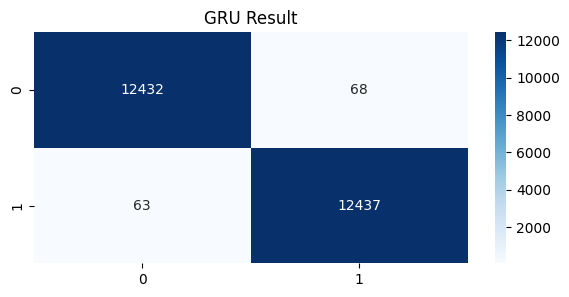

In [ ]:
cm = confusion_matrix(kdf['train'], kdf['pred'])

plt.figure(figsize=(7, 3))
sb.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
plt.title('GRU Result')
plt.show()
plt.close()